In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## grid modules

step fuction에 필요한 보조함수들입니다.

In [2]:
#Module

def gridboxIndicies(dimLength, dimProcs): #dimLength: original data length, 
                                          #dimProcs: number of grids depending on filtersize
    pointsPerBox = pointsPerGridbox(dimLength, dimProcs) #pointNums = np.ones(dimProcs,)

    idxs = np.zeros([dimProcs,2],dtype=np.int)
    
    for i,ppb in enumerate(pointsPerBox):
        idxs[i][1] = idxs[i][0] + ppb
        if i<dimProcs-1: idxs[i+1][0] = idxs[i][1]

    return idxs

In [3]:
def pointsPerGridbox(dimLength, dimProcs):

    pointNums = np.ones((dimProcs,),dtype=np.uint16)

    pts,rem = divmod(dimLength,dimProcs)

    pointNums *= pts

    if rem != 0:
        for i,num in enumerate(pointNums):
            if rem > 0:
                pointNums[i] = num+1
                rem -= 1
            else:
                continue

    return pointNums


In [4]:
def gridIndicies(pDim1,pDim2,dim1idxs,dim2idxs):

    dim1list = []
    dim2list = []

    for i in range(0,pDim1):
        for j in range(0,pDim2):
            dim1list.append(dim1idxs[i].tolist())
            dim2list.append(dim2idxs[j].tolist())

    return dim1list,dim2list

## step function

In [5]:
def stepfunction(array,fts):
    Qv, Hv, Lv = [], [], []
    filters = fts
    for filterSize in filters:

        xDim = array.shape[0]
        yDim = array.shape[1]

        xGrids = int(xDim / filterSize)
        yGrids = int(yDim / filterSize)

        xIdxs = gridboxIndicies(xDim, xGrids)
        yIdxs = gridboxIndicies(yDim, yGrids)

        x, y = gridIndicies(xGrids, yGrids, xIdxs, yIdxs)

        var = array
        filtered_grid = np.zeros_like(var, dtype=np.float64)
        for xi in range(0, yGrids):
            for yi in range(0, xGrids):
                xs = x[xi * yGrids + yi][0]
                xe = x[xi * yGrids + yi][1]
                ys = y[xi * yGrids + yi][0]
                ye = y[xi * yGrids + yi][1]
                filtered_grid[ys:ye, xs:xe] = np.mean(var[ys:ye, xs:xe])

        var_H = var - filtered_grid
        var_L = filtered_grid - np.mean(var)

        Qv.append(filtered_grid)
        Hv.append(var_H)
        Lv.append(var_L)
    return np.array(Qv), np.array(Hv), np.array(Lv)

<img align="left" src="./anigif_36.gif"><p><font size=3><br><h2>step function에 관하여</h2><br>
&ensp; step function은 2D array와 filter의 크기들을 인자로 받습니다. filter들은 array혹은 list일 수 있습니다. 이후 받은 filter크기 만큼의 2차원 window를 생성하여 입력받은 array를 지나며 해당하는 범위내의 값들을 평균해주게 됩니다. 예를들면 16x16의 array와 4의 filter size를 받았다면 4x4크기의 window를 생성하여 16x16의 array를 순회하며 window내에 포함되는 값들의 평균을 계산한 후 반환해 줍니다.
<p>&ensp;16x16 array와 [1,2,4]의 필터들을 받으면 1,2,4의 window size로 걸러진 3개의 array들을 합쳐서 최종적으로 3x16x16크기의 array를 반환합니다.</p>
<p>&ensp;왼쪽 그림은 step function이 어떻게 작동하는지에 대한 예시입니다.<font></p>

In [6]:
def divisors(integer):
    """
    어떤수의 모든 약수들을 구해줌 
    만약 16이라면 16의 약수인 1,  2,  4,  8, 16을 array로 반환
    """
    a = np.arange(1,integer+1)
    return a[np.where(np.mod(integer,a)==0)]

## MRspectrum function

In [7]:
def MRspectrum(array, fts, org_ar=False):
    qv = stepfunction(array, fts)[0]
    org_d = qv[0]
    binVar = np.zeros_like(fts, dtype=np.float64)
    for i in range(len(fts)-1):
        svar = np.array(qv[i], dtype=np.float64)
        bvar = np.array(qv[i+1], dtype=np.float64)
        binVar[i] = np.mean((org_d-bvar)**2)-np.mean((org_d-svar)**2)

    binVar = binVar/np.var(org_d)
    print("필터 :",fts)

    if org_ar:
        fig = plt.figure(figsize=(14, 6))
        fig.add_subplot(1, 2, 1)
        plt.plot(fts, binVar, 'g-o', ms=3.0)
        plt.xlabel(r'$\Delta$x', size='x-large')
        plt.xlabel(r'Filters', size='x-large')
        plt.ylabel(r'$D$', size='x-large')
        plt.ylim(0, 1)
        plt.xlim(fts[0]-0.5, fts[-1]+0.5)
        print("분산값들의 합 :",np.sum(binVar))

        fig.add_subplot(1, 2, 2)
        plt.pcolor(org_d, edgecolor='w', cmap='winter')
        
    else:
        plt.plot(fts, binVar, 'g-o', ms=3.0)
        plt.xlabel(r'$\Delta$x', size='x-large')
        plt.xlabel(r'Filters', size='x-large')
        plt.ylabel(r'$D$', size='x-large')
        plt.ylim(0, 1)
        plt.xlim(fts[0]-0.5, fts[-1]+0.5)
        print("분산값들의 합 :",np.sum(binVar))
    return binVar

<p>step function으로 필터한 데이터를 토대로 최종적으로 해당 데이터에 대한 MRspectrum을 구하는 함수입니다. 마찬가지로 array와 필터를 받습니다.</p>

아래 그림은 2x2크기의 event가 있는 18x18의 array를 MRspectrum분석한 결과입니다. 2x2크기의 event하나만 있으므로 2에서 peak가 찍혀나올 것을 예상할 수 있으며 약간의 노이즈가 있긴하나 실제로 2에서 peak가 찍힌것을 확인할 수 있습니다.

필터 : [ 1  2  4  8 16]
분산값들의 합 : 1.0


array([0.        , 0.76190476, 0.19047619, 0.04761905, 0.        ])

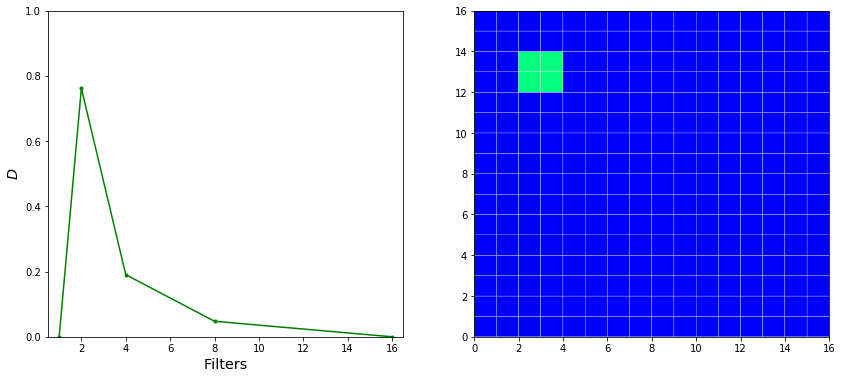

In [8]:
exam1 = np.ones((16, 16))
exam1[12:14, 2:4] = 11
MRspectrum(exam1, 2**np.arange(5), org_ar=True)

아래의 그림은 2x2의 event 2개와 6x6크기의 event하나가 존재하는 18x18의 array를 MRspectrum분석한 결과입니다. 4에서 피크가 나타난 것을 확인할 수 있습니다.

필터 : [ 1  2  4  8 16]
분산값들의 합 : 1.0


array([0.        , 0.16271186, 0.69152542, 0.14576271, 0.        ])

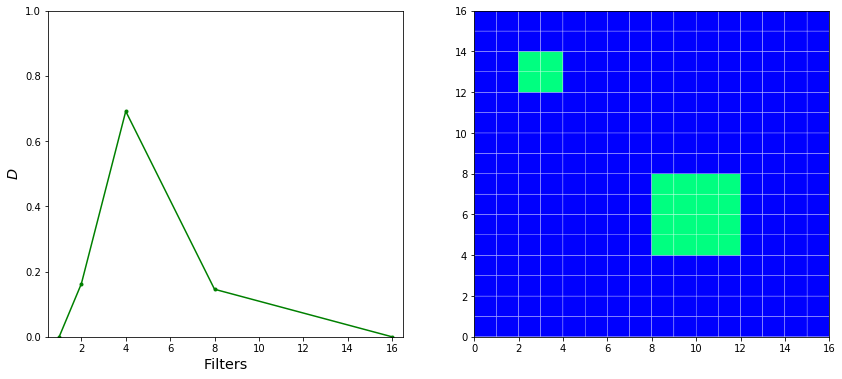

In [9]:
exam2 = np.ones((16, 16))
exam2[12:14, 2:4] = 11
exam2[4:8, 8:12] = 11
MRspectrum(exam2, 2**np.arange(5), org_ar=True)

아래의 그림은 바로위의 그림과 event의 크기, 개수는 같으나 위치가 다른 예시데이터입니다. 위의 그래프와 같은 형태를 나타낼 것으로 기대하였으나 기대와 다르게 2에서 피크가 찍힌것을 볼 수 있습니다.

필터 : [ 1  2  4  8 16]
분산값들의 합 : 1.0


array([0.        , 0.81355932, 0.14915254, 0.03728814, 0.        ])

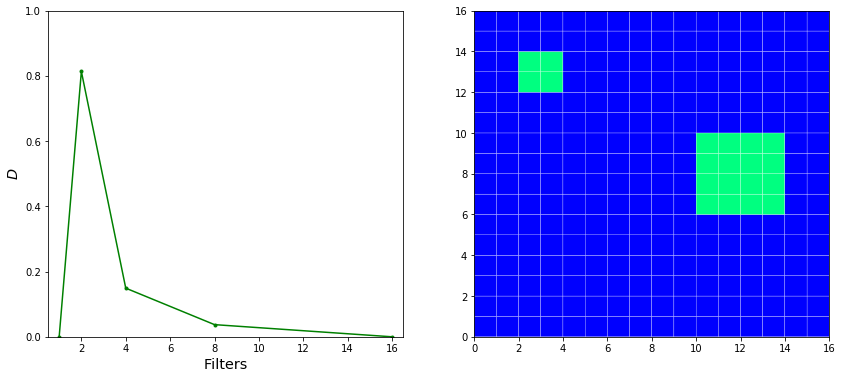

In [10]:
exam3 = np.ones((16, 16))
exam3[12:14, 2:4] = 11
exam3[6:10, 10:14] = 11
MRspectrum(exam3, 2**np.arange(5), org_ar=True)

<p>원인은 다음과 같은것으로 생각됩니다.</p>
<p>아래 그림의 첫번째 줄은 exam2의 raw데이터와 4x4 filtered데이터 그리고 MRspectrum이며, 두번째 줄은 exam3의 raw데이터, 4x4 filtered데이터, MRspectrum입니다.<br> exam2에서는 4x4의 window가 필터를 수행할때 4x4크기를 가진 event의 위치와 필터링을 수행하는 window의 경로가 일치하여 평균하는 과정에서 최대값을 줄이지 않은것을 볼 수 있습니다. 하지만 exam3에서는 필터링하는 과정에서 event의 최대값이 줄어들어 스펙트럼의 결과가 약간 바뀐것을 확인할 수 있습니다.</p>

필터 : [ 1  2  4  8 16]
분산값들의 합 : 1.0
필터 : [ 1  2  4  8 16]
분산값들의 합 : 1.0


Text(0.5, 1.0, 'exam3 MRspectrum')

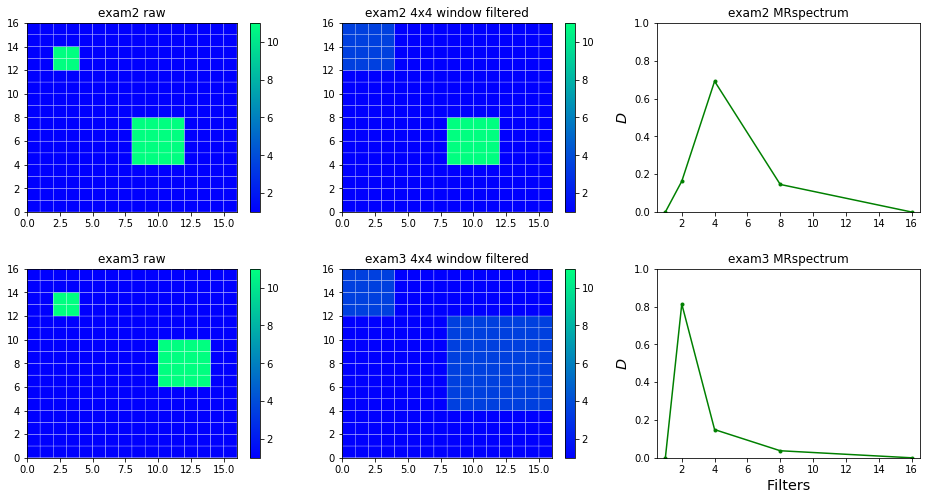

In [11]:
fig = plt.figure(figsize=(16, 8))
fig.subplots_adjust(hspace=0.3,wspace=0.2)

fig.add_subplot(2, 3, 1)
plt.pcolor(exam2, edgecolor='w', cmap='winter',vmin=1,vmax=11)
plt.colorbar()
plt.title("exam2 raw")

fig.add_subplot(2, 3, 2)
plt.pcolor(stepfunction(exam2,[4])[0][0], edgecolor='w', cmap='winter',vmin=1,vmax=11)
plt.colorbar()
plt.title("exam2 4x4 window filtered")

fig.add_subplot(2, 3, 3)
MRspectrum(exam2, 2**np.arange(5))
plt.xlabel("")
plt.title("exam2 MRspectrum")

fig.add_subplot(2, 3, 4)
plt.pcolor(exam3, edgecolor='w', cmap='winter',vmin=1,vmax=11)
plt.colorbar()
plt.title("exam3 raw")

fig.add_subplot(2, 3, 5)
plt.pcolor(stepfunction(exam3,[4])[0][0], edgecolor='w', cmap='winter',vmin=1,vmax=11)
plt.colorbar()
plt.title("exam3 4x4 window filtered")

fig.add_subplot(2, 3, 6)
MRspectrum(exam3, 2**np.arange(5))
plt.title("exam3 MRspectrum")

## 필터의 크기와 관련하여...

지금까지 이해한 바로는 필터크기의 조건이 $2^{n}$인 이유는 다음과 같다고 생각됩니다.<br>
필터링을 하는 과정에서 window의 크기는 항상 동일하게 유지되어야 합니다. 만약 16x16의 array를 3x3의 윈도우로 필터링을 수행한다면 15번째 인덱스까지 같은 크기의 window로 필터링이 수행되지만 남은 인덱스의 크기가 1x16이므로 3x3의 윈도우로 필터링을 수행할 수 없게 됩니다. 따라서 해당조건을 맞춰주기 위하여 다음의 두가지 자료처리를 하게 됩니다.
- array를 자르거나 내삽하여 크기를 가장 가까운 $2^{n}$값으로 맞춰준다
- $2^{n}$를 만족하는 수들로 필터링을 수행한다.

<font color="red" size=5><b>만약 또다른 이론적 배경이 있다면 아래의 내용은 모두 틀린것이므로 안보셔도 됩니다.</b></font>

필터의 크기가 $2^{n}$이어야 하는 이유가 위와 같다면 제 생각은 다음과 같습니다.<br>
만약 어떤 array를 같은 크기로 나누는 조건을 만족하면 되는것이라면 가장 많은 filter를 구할 수 있는 방법은 해당 수의 약수를 구하는 것이라 생각이 됩니다. 만약 1030x1030크기의 array에 대한 MRspectrum을 구한다고 가정했을때 1030과 가장 가까운 2의 제곱수는 1024로 $2^{11}$입니다. $2^{11}$일때 구할 수 있는 필터는 다음과 같습니다.

In [12]:
2**np.arange(11)

array([   1,    2,    4,    8,   16,   32,   64,  128,  256,  512, 1024],
      dtype=int32)

1은 사실상 의미를 갖기 어려우므로 10개가 필터의 수라고 할 수 있겠습니다. 하지만 1030보다 10 작은 1020의 약수는 다음과 같습니다

In [13]:
print(len(divisors(1020)))
divisors(1020)

24


array([   1,    2,    3,    4,    5,    6,   10,   12,   15,   17,   20,
         30,   34,   51,   60,   68,   85,  102,  170,  204,  255,  340,
        510, 1020])

1020은 총 24개의 약수를 가지며 1을 빼면 23개가 됩니다. 이러한 방법을 사용하면 $2^{n}$으로 하는 방법과 비교하여 2배가 넘는 해상도를 가지게 됩니다.<br>
다음으로는 일반적으로 이러한 조건을 만족하는가에 대하여 알아보겠습니다.

<p>$2^{n}$방법은 특성상 사용가능한 필터의 개수가 array의 크기에 의존하게 되며 $2^{n}$이라는 지수함수의 특성상 n이 증가할때마다 그 크기가 매우 커지게 됩니다. n이 10이상 즉, 10개 이상의 필터를 사용하기 위해서는 1000x1000 이상의 매우 큰 array를 요구하게 되며 때로는 메모리에 데이터를 다 올리지 못하여 분산처리를 하지 않고는 계산이 불가능한 경우가 야기될 수 있습니다. 또한 array의 크기가 애매할경우 많은양의 데이터를 버리게 될수도 있습니다. 예를들면, 400x400 array일 경우 가까운 $2^{n}$으로 크기를 맞춰주려면 데이터를 그냥써도, 내삽을 해도 100 array 이상의 많은 데이터를 버려야 합니다.
</p>
<p>
아래의 그림은 100이상 512이하의 구간에서 어떤수 $i$가 자신보다 $x$만큼 작은 구간이내(그래프에서 $x$축)에서 10개(빨간선), 15개(파란선)이상의 약수를 가질 확률(그래프에서 $y$축)을 계산한 그래프입니다. 
</p>
<p>
그래프를 해석하면 자신보다 5만큼 작은 구간 내에서 10개 이상의 약수를 가질 확률이 80%이상이며 10만큼 작은 구간에서는 95%이상 이라는 것을 알 수 있습니다. 즉, array가 100이상 512이하 일때 array를 5개 이하로 버렸을때 최소한 10개 이상의 약수를 80% 이상의 확률로 보장한다는 뜻으로 해석할 수 있습니다. 약수라는 것은 곧 필터의 개수로 해석할 수 있습니다.
</p>

Text(0.5, 1.0, '100 ~ 512')

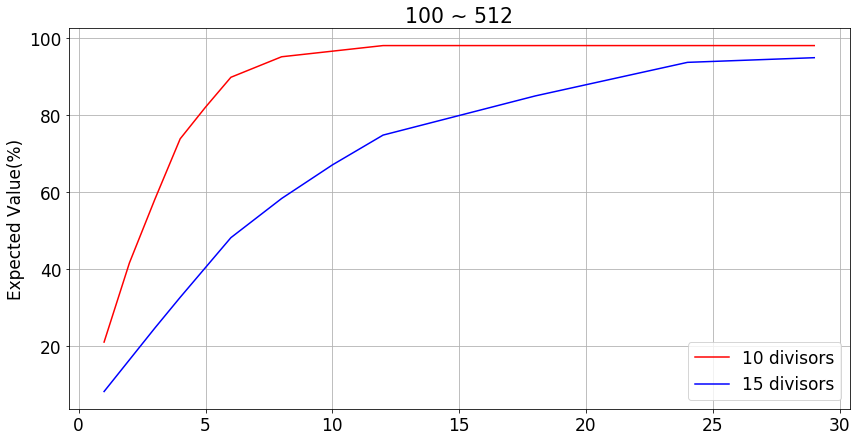

In [14]:
datas10 = []
datas15 = []
for i in range(1,30):
    grids = [[len(divisors(i)),i] for i in range(100, 513)]
    maxdata = pd.DataFrame(np.array(grids)[:,0]).rolling(window=i,min_periods=1).max()
    datas10.append(sum(maxdata[0]>=10)/len(maxdata)*100)
    datas15.append(sum(maxdata[0]>=15)/len(maxdata)*100)

x = range(1,30)
fig = plt.figure(figsize=(14, 7))
plt.rcParams.update({'font.size': 17})
plt.plot(x,datas10,label="10 divisors",color='r')
plt.plot(x,datas15,label="15 divisors",color='b')
plt.ylabel("Expected Value(%)")
plt.legend(loc=4)
plt.grid()
plt.title("100 ~ 512")

### 아래의 그래프는 513이상 1024이하 구간에서의 손실 array구간별 10이상, 15이상 약수 보장확률입니다.

Text(0.5, 1.0, '513 ~ 1024')

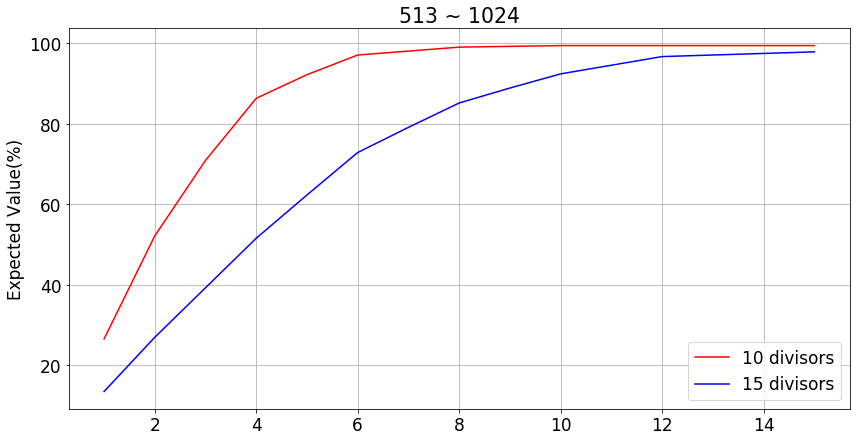

In [15]:
datas10 = []
datas15 = []
for i in range(1,16):
    grids = [[len(divisors(i)),i] for i in range(513, 1025)]
    maxdata = pd.DataFrame(np.array(grids)[:,0]).rolling(window=i,min_periods=1).max()
    datas10.append(sum(maxdata[0]>=10)/len(maxdata)*100)
    datas15.append(sum(maxdata[0]>=15)/len(maxdata)*100)
x = range(1,16)
fig = plt.figure(figsize=(14, 7))
plt.rcParams.update({'font.size': 17})
plt.plot(x,datas10,label="10 divisors",color='r')
plt.plot(x,datas15,label="15 divisors",color='b')
plt.ylabel("Expected Value(%)")
plt.legend(loc=4)
plt.grid()
plt.title("513 ~ 1024")

<p>
이러한 결과는 $2^{n}$방법과 비교하여 필터 개수가 array의 크기에 대한 의존성을 대폭 줄여주며 더 적은 개수의 array를 버리고 더 많은 개수의 필터를 보장해 준다는 것을 의미한다고 생각합니다. 물론 아래의 그래프를 본다면 array의 크기에 대한 의존성이 완전히 제거되지는 않으나 매우 큰 폭으로 줄여주는 것으로 보입니다.
</p>

Text(0, 0.5, 'the number of divisors')

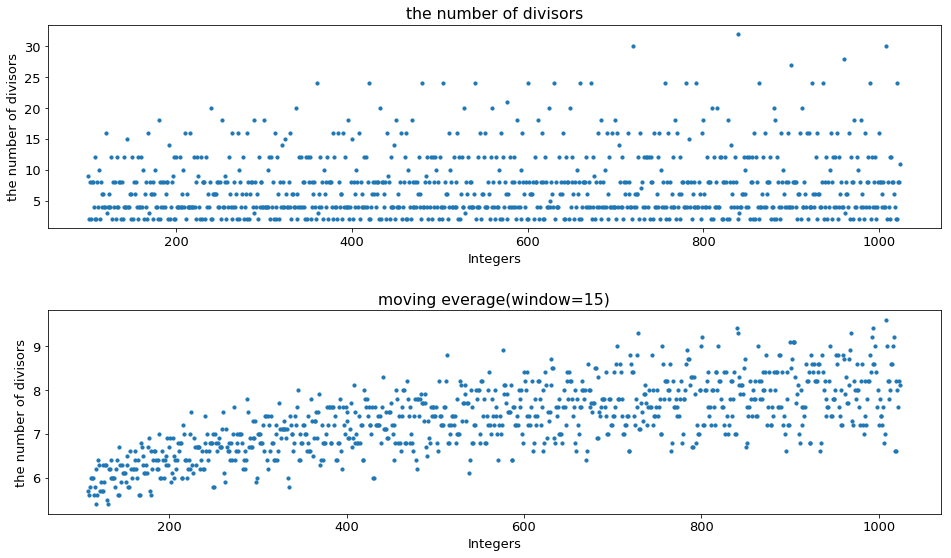

In [16]:
grids = [[len(divisors(i)),i] for i in range(100, 1025)]

fig = plt.figure(figsize=(16,9))
fig.subplots_adjust(hspace=0.4)
plt.rcParams.update({'font.size': 13})
fig.add_subplot(2,1,1)
plt.scatter(np.array(grids)[:,1],np.array(grids)[:,0],s=10)
plt.xlabel("Integers")
plt.ylabel('the number of divisors')
plt.title('the number of divisors')

fig.add_subplot(2,1,2)
plt.scatter(np.array(grids)[:,1],pd.DataFrame(np.array(grids)[:,0]).rolling(window=10).mean(),s=10)
plt.title('moving everage(window=15)')
plt.xlabel("Integers")
plt.ylabel('the number of divisors')

## 마지막으로 $2^{n}$방법과 array의 약수들로 MRspectrum을 구한 예제입니다.

### $2^{n}$방법

필터 : [  1   2   4   8  16  32  64 128]
분산값들의 합 : 1.0


array([0.0124704 , 0.10813146, 0.05738843, 0.13555402, 0.20229013,
       0.22709504, 0.25707052, 0.        ])

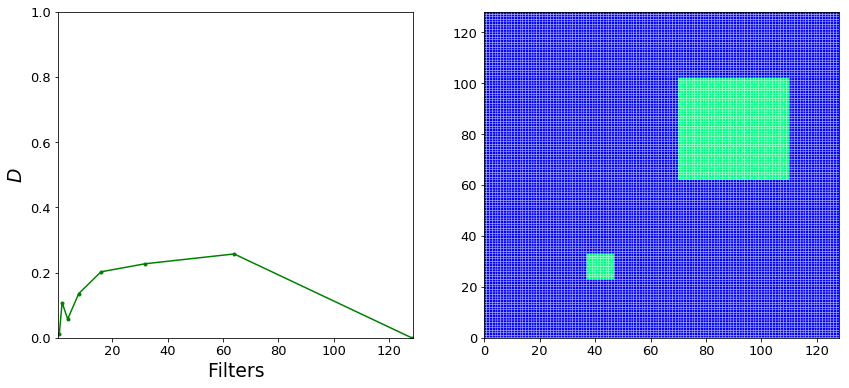

In [17]:
exam4 = np.ones((128, 128))
exam4[62:102, 70:110] = 11 # 40x40 size event
exam4[23:33, 37:47] = 11   # 10x10 size event
MRspectrum(exam4, 2**np.arange(8), org_ar=True)

### 약수(divisor)를 이용한 방법

필터 : [  1   2   3   6   7   9  14  18  21  42  63 126]
분산값들의 합 : 1.0


array([ 0.01251676,  0.05218978,  0.06214464,  0.00839978,  0.05405391,
        0.07188006,  0.08079355,  0.01296641,  0.49998041, -0.14086011,
        0.2859348 ,  0.        ])

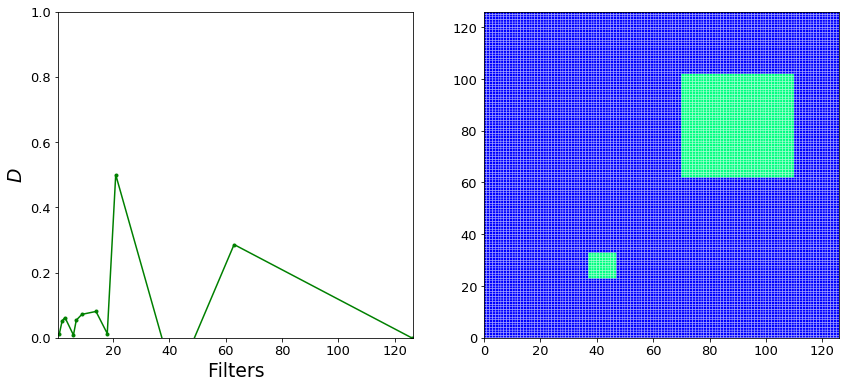

In [18]:
exam5 = np.ones((126, 126))
exam5[62:102, 70:110] = 11 # 40x40 size event
exam5[23:33, 37:47] = 11   # 10x10 size event
MRspectrum(exam5, divisors(126), org_ar=True)